# Floating Population Data

In [1]:
using DataFrames, CSV, Plots, Wavelets, Clustering
using Distances, LinearAlgebra, Loess, StatsBase, Statistics

include("../../../autocorrelation-shell/src/AutocorrelationShell.jl")
using Main.AutocorrelationShell

In [2]:
float_pop = CSV.read("../data/float_pop_sorted.csv")

32×519 DataFrame. Omitted printing of 516 columns
│ Row │ cityname  │ 2019-06-01 10:00:00 │ 2019-06-01 11:00:00 │
│     │ String    │ Float64             │ Float64             │
├─────┼───────────┼─────────────────────┼─────────────────────┤
│ 1   │ Chiyoda   │ 1039.0              │ 1113.0              │
│ 2   │ Chuo      │ 711.0               │ 744.0               │
│ 3   │ Minato    │ 1031.0              │ 1144.0              │
│ 4   │ Bunkyo    │ 365.0               │ 398.0               │
│ 5   │ Koutou    │ 727.0               │ 809.0               │
│ 6   │ Shibuya   │ 889.0               │ 988.0               │
│ 7   │ Shinagawa │ 613.0               │ 724.0               │
│ 8   │ Shinjuku  │ 920.0               │ 1022.0              │
│ 9   │ Adachi    │ 549.0               │ 581.0               │
│ 10  │ Arakawa   │ 266.0               │ 295.0               │
⋮
│ 22  │ Suginami  │ 518.0               │ 591.0               │
│ 23  │ Sumida    │ 444.0               │ 416.0               │
│ 24  │ Toshima   │ 551.0               │ 622.0               │
│ 25  │ Akishima  │ 92.0                │ 88.0                │
│ 26  │ Chofu     │ 246.0               │ 298.0               │
│ 27  │ Fuchu     │ 253.0               │ 254.0               │
│ 28  │ Hachioji  │ 381.0               │ 398.0               │
│ 29  │ Machida   │ 323.0               │ 394.0               │
│ 30  │ Mitaka    │ 156.0               │ 187.0               │
│ 31  │ Tachikawa │ 202.0               │ 206.0               │
│ 32  │ Ome       │ 60.0                │ 83.0                │

**Note**: Refer to the python notebook for clustering and preprocessing.

## 1. AC2D Transform

In [3]:
H = wavelet(WT.db2)
L = 6
Q = qfilter(H)
P = pfilter(H)

7-element Array{Float64,1}:
 -0.044194173824159244 
 -5.887846720064156e-17
  0.397747564417433    
  0.7071067811865475   
  0.397747564417433    
 -5.887846720064156e-17
 -0.044194173824159244 

In [4]:
X = Matrix(float_pop[2:513])
D = ac2d(X, 1, 1, P, Q)
"muting output"

┌ Warning: `getindex(df::DataFrame, col_inds::Union{AbstractVector, Regex, Not})` is deprecated, use `df[:, col_inds]` instead.
│   caller = top-level scope at In[4]:1
└ @ Core In[4]:1


"muting output"

## 2. Thresholding

### Histogram of Coefficients

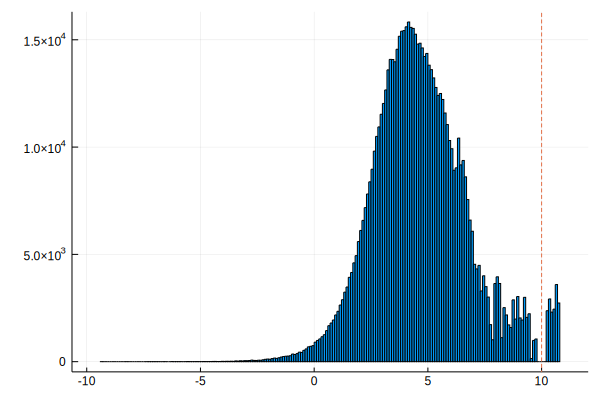

In [9]:
histogram(log.(abs.(D[:])), legend = false)
vline!([10], style=:dash)

The plot above displays the distribution of the absolute log transformed coefficients. Overall, it is a clean bell curve but the right tail of the distribution, where the magnitude of the coefficients become larger, is distorted. We can see that there is a smaller mound on large coefficients that are separated from the main body.

### Large Coefficients

We begin by examining the separate mound of large coefficients by hard thresholding the coefficients at $log(10)$ and reconstructing the signal with the large coefficients alone.

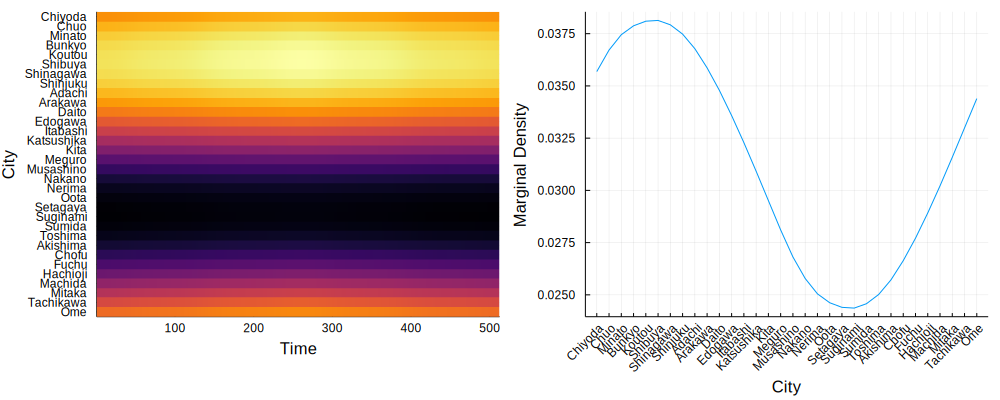

In [23]:
T = acthreshold(D, "hard", exp(10))
R = iac2d(T)

h₁ = heatmap(
    R, 
    xlabel = "Time",
    ylabel = "City",
    yticks = ([1:1:32;], float_pop[!, :cityname]),
    legend = false, 
    yflip = true
)

p₁ = plot(
    sum(R, dims=2)/sum(R),
    xlabel = "City",
    ylabel = "Marginal Density",
    xticks = ([1:1:32;], float_pop[!, :cityname]),
    xrotation = 45,
    legend = false
)

plot(h₁, p₁, layout=(1, 2), size=(1000, 400))

The plot on the left shows the heatmap for the reconstructed signal, using only the large coefficients. The plot on the right shows the marginal density for the y axis (City) for the reconstructed signal. We can see that the large coefficients seems to be extracting the trend among cities. However, we must be careful here because, the shape of the marginal density is a very smooth sinusoid curve, which maybe an artifact from the implementation. 

If indeed we made the assumption of periodicity in the implementation, then the large coefficients maybe due to discontinuity, because wavelets produce large coefficients when there suddent jumps within the sigal. Therefore we need to fix the problem of head and tail mismatch.

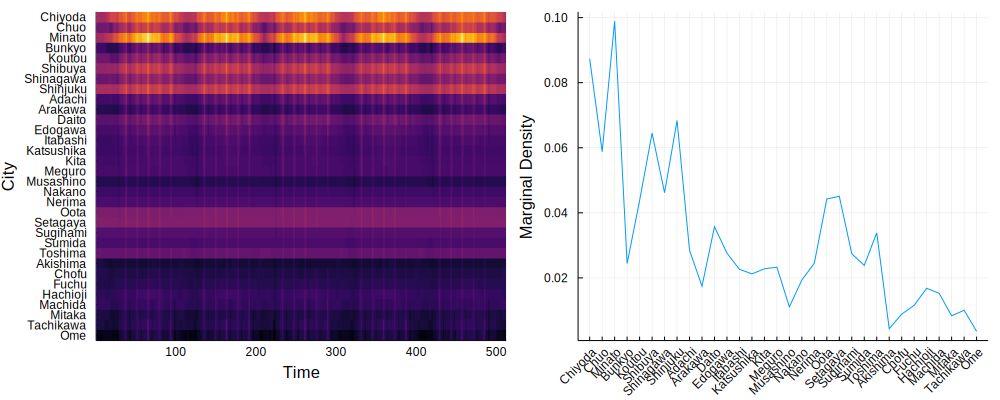

In [24]:
T = acthreshold(D, "hard", exp(7))
R = iac2d(T)

h₁ = heatmap(
    R, 
    xlabel = "Time",
    ylabel = "City",
    yticks = ([1:1:32;], float_pop[!, :cityname]),
    legend = false, 
    yflip = true
)

p₁ = plot(
    sum(R, dims=2)/sum(R),
    xlabel = "City",
    ylabel = "Marginal Density",
    xticks = ([1:1:32;], float_pop[!, :cityname]),
    xrotation = 45,
    legend = false
)

plot(h₁, p₁, layout=(1, 2), size=(1000, 400))

If we threshold at $exp(8)$ we see that the weekly trend information beginning to appear. There is also a dramatic change in the marginal density plot compared to when we threshold at $exp(10)$. Thus can we interpret the large separate coefficients as intercepts?

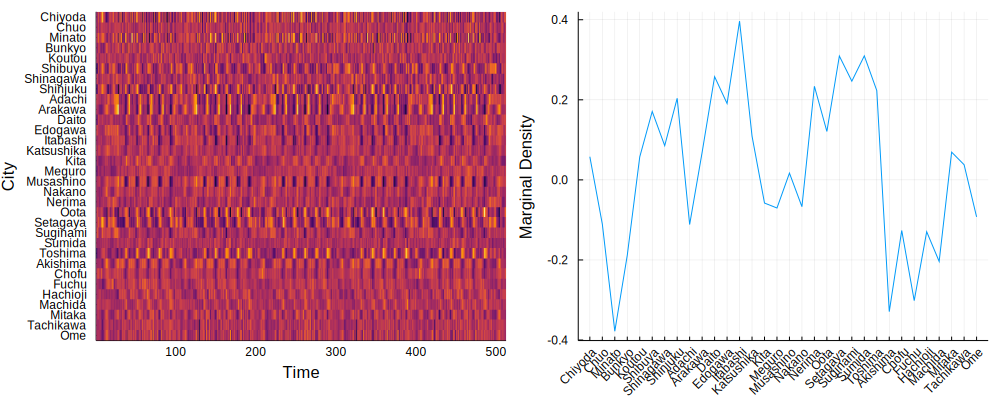

In [169]:
T = acthreshold(D, "hard", exp(5))
T₁ =  D - T # remove large coefficient
R₁ = iac2d(T₁)

h₁ = heatmap(
    R₁, 
    xlabel = "Time",
    ylabel = "City",
    yticks = ([1:1:32;], float_pop[!, :cityname]),
    legend = false, 
    yflip = true
)

p₁ = plot(
    sum(R₁, dims=2)/sum(R₁),
    xlabel = "City",
    ylabel = "Marginal Density",
    xticks = ([1:1:32;], float_pop[!, :cityname]),
    xrotation = 45,
    legend = false
)

plot(h₁, p₁, layout=(1, 2), size=(1000, 400))

Throwing away most of the larger coefficients reveals the finer trends within the data. Note that cities at the top and bottom e.g. Chiyoda, Chuo, Minato, Tachikawa, Ome display very fine trends, while cities in the middle are more rough.

## 3. Detrending

### Loess Detrending

**Loess detrending for the time axis**

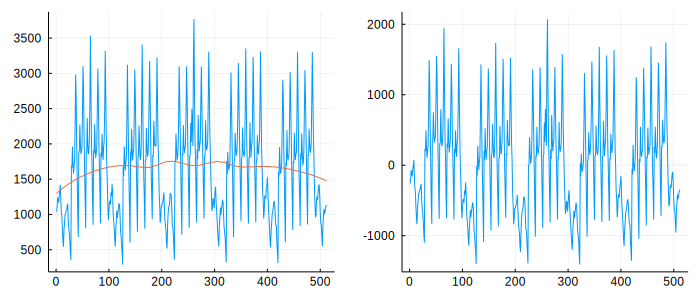

In [10]:
x = collect(1:512)
y = X[1,:]
Σ = loess(x, y)

Δ = range(extrema(x)...; step = 0.1)
vs = Loess.predict(Σ, Δ)

p1 = plot(x,y,legend=:none)
plot!(Δ, vs)

p2 = plot(x,y - vs[1:10:end], legend=:none)

plot(p1, p2,layout = (1, 2),size=(700,300))

Looses the small differences within the weeks

**Loess detrending for the city axis**

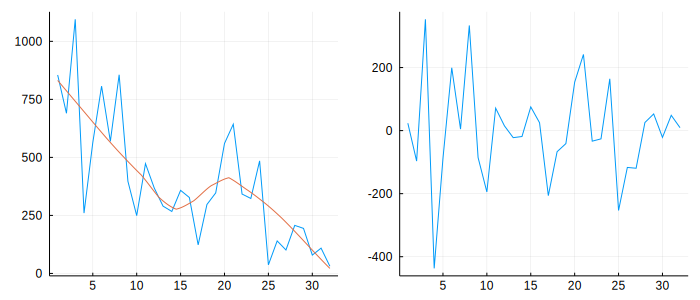

In [11]:
x = collect(1:32)
y = X[:,70]
σ = loess(x ,y)

Δ = range(extrema(x)...; step = 0.1)
Σ = Loess.predict(σ, Δ)

p1 = plot(x,y,legend=:none)
plot!(Δ, Σ)

p2 = plot(x,y - Σ[1:10:end], legend=:none)

plot(p1, p2,layout = (1, 2),size=(700,300))

Removes the difference between the cities. Also, can see sort of a wave form trend.

In [12]:
function fitLoess(X, i, axis)
    """
    Input:
        X -- data matrix
        i -- index of row or column to normalize
        axis -- "2" to normalize rows, "1" to normalize columns
    Output:
        loess curve for the specified index
    """
    xs = collect(1:size(X)[axis])
    if axis == 2
        ys = X[i,:]
    else
        ys = X[:,i]
    end
    σ = loess(xs, ys)
    
    Δ = range(extrema(xs)...; step = 0.1)
    Σ = Loess.predict(σ, Δ)[1:10:end]
    return Σ
end

fitLoess (generic function with 1 method)

In [13]:
function fitLoess1D(X, axis)
    nrows, ncols = size(X)
    Σ = Array{Float64, 2}(undef, nrows, ncols)
    if axis == 2
        for i in 1:nrows
            Σ[i,:] = fitLoess(X, i, axis)
        end
    else
        for i in 1:ncols
            Σ[:,i] = fitLoess(X, i, axis)
        end
    end
    return Σ
end

fitLoess1D (generic function with 1 method)

In [14]:
function fitLoess2D(X)
    nrows, ncols = size(X)
    Σ = Array{Float64, 2}(undef, nrows, ncols)
    Σ = fitLoess1D(X, 1)
    Σ += fitLoess1D(X, 2)
    return Σ
end

fitLoess2D (generic function with 1 method)

In [15]:
detrendLoess1D(X, axis) = X - fitLoess1D(X, axis)
detrendLoess2D(X) = X - fitLoess2D(X)

detrendLoess2D (generic function with 1 method)

**Detrending, Thresholding, and Reconstruction**

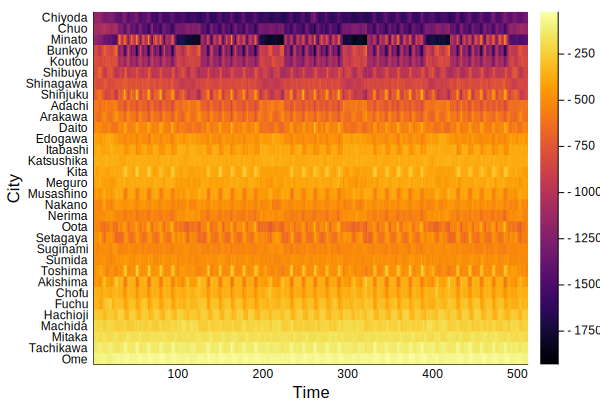

In [16]:
Xd₁ = detrendLoess2D(X)

Hd₁ = heatmap(
    Xd₁,
    xlabel = "Time",
    ylabel = "City",
    yticks = ([1:1:32;], float_pop[!, :cityname]),
    legend = true, 
    yflip = true
)

In [28]:
Dd₁ = ac2d(Xd₁, 1, 1, P, Q)
histogram(Dd₁[:], legend=false, xlim=[-500, 500])


Threshold at $exp(7)$

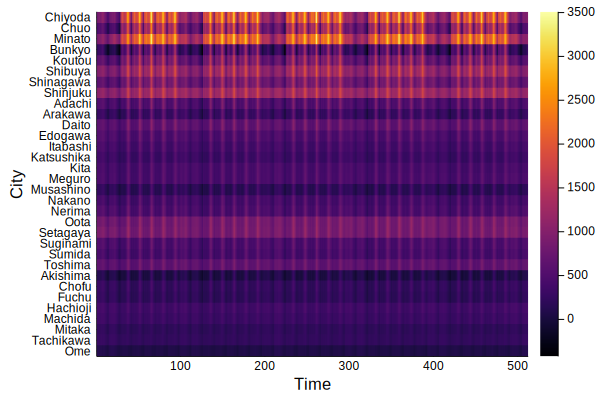

In [19]:
Td₁ = acthreshold(Dd₁, "hard", exp(7))
Rd₁ = iac2d(Td₁)
Rd₁ += fitLoess2D(X) # add back trends

heatmap(
    Rd₁,
    xlabel = "Time",
    ylabel = "City",
    yticks = ([1:1:32;], float_pop[!, :cityname]),
    legend = true, 
    yflip = true
)

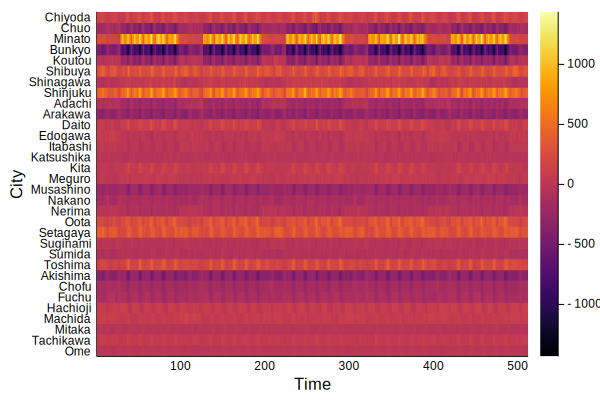

In [20]:
Xd₂ = detrendLoess1D(X, 1)

Hd₂ = heatmap(
    Xd₂,
    xlabel = "Time",
    ylabel = "City",
    yticks = ([1:1:32;], float_pop[!, :cityname]),
    legend = true, 
    yflip = true
)

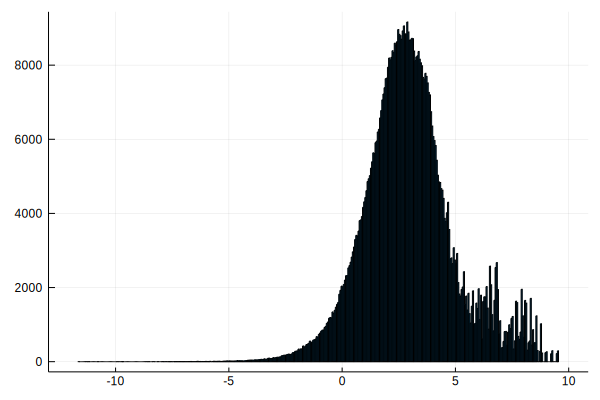

In [21]:
Dd₂ = ac2d(Xd₂, 1, 1, P, Q)
histogram(log.(abs.(Dd₂[:])), legend=false)

When we detrend by column, is seems as if alot of the large coefficients have disappeared. From this we can infer that the large coefficients were encoding the population i.e. smartphone log counts for each city. Considering that the mother wavelet is a weighted average over the entire signal, the large coefficients are acting as a sort of constant term or an intercept.

**Question**: Detrending the data led the removing the large coefficients. This means that the large coefficients are encoding the general trend. Thus, we can consider thresholding and reconstructing the signal as a detrending operation(?). Can wavelets be used as a detrending method?

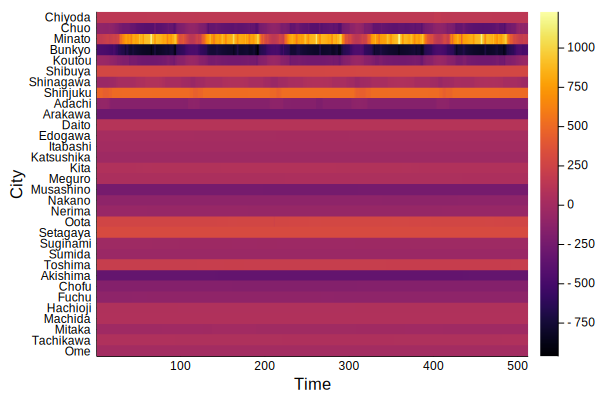

In [22]:
Td₂ = acthreshold(Dd₂, "hard", exp(6))
Rd₂ = iac2d(Td₂)
# Rd₂ += fitLoess2D(X) # add back trends

heatmap(
    Rd₂,
    xlabel = "Time",
    ylabel = "City",
    yticks = ([1:1:32;], float_pop[!, :cityname]),
    legend = true, 
    yflip = true
)

### Linear Detrending